In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# read dataset
dataset_path = 'sonar.all-data'
# number of features
n_features = 60
# name the feature and target columns
data = pd.read_csv(dataset_path, sep=",", names=np.append(np.arange(n_features),['Y']))

In [2]:
# convert ir to dataframe
trainset = pd.DataFrame(data)

# transform Minerals in 0 and Rocks in 1
trainset = trainset.replace('M',0)
trainset = trainset.replace('R',1)

In [78]:
import numpy as np
from tqdm import tqdm
import pickle
import pandas as pd

class NNetwork:
    def __init__(self, n_input, hidden_layer_size):
        self.n_input = n_input
        self.hidden_layer_size = hidden_layer_size
        self.n_cat = 1
        
        # initialize weights
        self.w_1 = np.random.randn(self.hidden_layer_size, self.n_input)
        self.w_2 = np.random.randn(self.hidden_layer_size, self.hidden_layer_size)
        self.w_3 = np.random.randn(self.n_cat, self.hidden_layer_size)

        # initialize biases
        self.b_1 = np.random.randn(self.n_input, 1)
        self.b_2 = np.random.randn(self.hidden_layer_size, self.hidden_layer_size)
        self.b_3 = np.random.randn(self.n_cat, 1)
        
    def train(self, trainset_i, n_epochs, alpha, n_samples):
        """
        train a fully connected neural network using the specified train_set (dataframe)
        """
        if (trainset_i).shape[1]-1 != self.n_input:
            raise ValueError(u"X_train size has to be the same as the Network inputs")

        i = 0
        cost = np.zeros(n_epochs)

        while i < n_epochs:            
            subset = trainset_i.sample(n_samples)
            dw1 = db1 = dw2 = db2 = dw3 = db3 = 0
            for index, element in subset.iterrows():
                
                X_train = element[:-1]
                Y_train = element[self.n_input]
                dim1 = X_train.shape
                
                element = X_train.values.reshape((dim1[0], 1))
             
                z_1 = self.w_1.dot(element) + self.b_1    # input weight
                a_1 = self.__relu(z_1)                   # pass through ReLU non-linearity          

                # pass though the hidden layer 2
                z_2 = self.w_2.dot(a_1) + self.b_2
                # Activation function
                a_2 = self.__relu(z_2) # predict class probabilities with the softmax activation function
                
                # pass though the hidden layer 2
                z_3 = self.w_3.dot(a_2) + self.b_3
                # Activation function
                a_3 = self.__sigmoid(z_3) # predict class probabilities with the softmax activation function
                # Loss
                Yh = a_3
                
                loss = self.__squared_loss(Yh, Y_train)
                cost[i] += loss
               
                # derivative of the loss function w.r.t. output a_3
                dz3 = Yh - Y_train
                dw3 += np.dot(dz3, a_2)
                db3 += np.dot(dz3, np.ones([dz3.shape[1],1]))
                
                aux2 = self.w_3.T * dz3
                dz2 = aux2 * self.__relu_derivative(z_2)
                dw2 += np.dot(dz2, a_1)
                db2 += np.dot(dz2, np.ones([dz2.shape[1],1]))
                
                aux1 = self.w_2.T * dz2
                dz1 = aux1 * self.__relu_derivative(z_1)
                dw1 += np.dot(dz1, element)
                db1 += np.dot(dz1, np.ones([dz1.shape[1],1]))

            # Update the weight and biases
            self.w_1 -= dw1/n_samples * alpha
            self.b_1 -= db1/n_samples * alpha
            self.w_2 -= dw2/n_samples * alpha
            self.b_2 -= db2/n_samples * alpha
            self.w_3 -= dw3/n_samples * alpha
            self.b_3 -= db3/n_samples * alpha

            params = [self.w_1, self.b_1, self.w_2, self.b_2, self.w_3, self.b_3]

            i += 1
        to_save = [params, cost/float(n_samples)]
    
        with open('model', 'wb') as file:
            pickle.dump(to_save, file)

        return cost/float(n_samples), params
    
    def predict(self, element, w1, b1, w2, b2, w3, b3):
        '''
        Make predictions with trained filters/weights. 
        '''
        element = element[:-1]
        fc = element.values.reshape((n_features, 1)) # flatten pooled layer

        z1 = w1.dot(fc) + b1 # first dense layer
        a1 = self.__relu(z1) # pass through ReLU non-linearity
        
        z2 = w2.dot(a1) + b2 # first dense layer
        a2 = self.__relu(z2) # pass through ReLU non-linearity

        z3 = w3.dot(a2) + b3 # first dense layer
        a3 = self.__sigmoid(z3) # pass through ReLU non-linearity
        
        # print(a2)
        probs = a3
        return (np.argmax(probs), np.max(probs))
    
    #### private methods
    
    def __squared_loss(self, probs, labels):
        return np.sum((probs - labels)**2)*0.5
    
    def __relu_derivative(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    def __relu(self, X):
        return np.maximum(0, X)

    def __sigmoid(self, Z):
        return 1/(1+np.exp(-Z))
    
    def __dev_sigmoid(self, Z):
        s = 1/(1+np.exp(-Z))
        dZ = s * (1 - s)
        return dZ

In [79]:
# Initialize the network:
n_neurons_per_hidden_layer = 60
network = NNetwork(n_features, n_neurons_per_hidden_layer)

In [80]:
# train the network
# trainset with features in the first 60 columns and the labels in the last one
n_epoch = 10000
alpha = 1e-3
bach_size = 207

cost, params = network.train(trainset, n_epoch, alpha, bach_size)

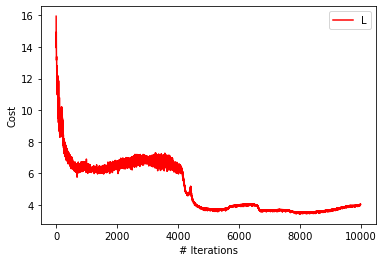

In [81]:
# Plot cost 
plt.plot(cost, 'r')
plt.xlabel('# Iterations')
plt.ylabel('Cost')
plt.legend('Loss', loc='upper right')
plt.show()

In [82]:
# load saved parameters
params, cost = pickle.load(open('model', 'rb'))
[w_1, b_1, w_2, b_2, w3, b3] = params


# predict using the learned model
prediction = np.array([])
for i in np.arange(trainset.shape[0]):
    prediction = np.append(prediction, network.predict(trainset.iloc[i], w_1, b_1, w_2, b_2, w3, b3)[1])
    # break
print(np.round(prediction))
prediction = np.round(prediction)

[1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]


In [83]:
# print(w_1, b_1, w_2, b_2)

In [84]:
TP = TN = FP = FN = 0
for i in np.arange(len(prediction)):
    TP += trainset["Y"][i]==prediction[i] and trainset["Y"][i] == 1
    TN += trainset["Y"][i]==prediction[i] and trainset["Y"][i] == 0
    FP += not(trainset["Y"][i]==prediction[i]) and trainset["Y"][i] == 1
    FN += not(trainset["Y"][i]==prediction[i]) and trainset["Y"][i] == 0
Accuracy = (TP + TN) / float(len(prediction))
Precision = TP / float(TP + FP)
Recall = TP / float(TP + FN)

print("Accuracy", Accuracy)
print("Precision", Precision)
print("Recall", Recall)

Accuracy 0.7163461538461539
Precision 0.9278350515463918
Recall 0.6338028169014085


In [77]:
np.array(trainset["Y"])

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])